# 📌 LSTM 모델을 이용한 니켈 가격 예측

### 사용변수 : 광물종합지수, 메이저금속지수, 시장전망지표, 무역수지, 환율, 2차전지 산업지수 

In [84]:
#!pip install torchvision

In [85]:
import torch
import torch.nn
import torchvision.transforms as transforms
import torchvision.datasets
from torch.autograd import Variable
from torch.nn import Parameter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [86]:
plt.style.use('seaborn-whitegrid')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)

if torch.cuda.is_available() :
    torch.cuda.manual_seed_all(125)

C:\Users\wandong\AppData\Local\Temp\ipykernel_25956\1616429856.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. 데이터 형태 확인

In [87]:
import pandas as pd
import numpy as np
df=pd.read_csv('../../data/final/니켈data.csv',encoding='cp949')
주식=pd.read_csv('../../data/final/주식.csv',encoding='cp949')
df=pd.merge(df,주식,left_on='기준일',right_on='Date',how='left')
df=df[df['기준일']<'2024-05-01']
df

,기준일,기준가격,광물종합지수,메이저금속지수,환율,시장전망지표,무역수지,수출 중량,수출 금액,수입 중량,...,삼성SDI,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가
0,2021-06-09,18088,2407.510943,2494.113774,1116.890015,12.57,-26962.0,0.0,0.0,311072.1,...,0.550586,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387
1,2021-06-10,17783,2436.458355,2523.494802,1116.410034,12.57,-26962.0,0.0,0.0,311072.1,...,0.559105,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924
2,2021-06-11,18303,2452.915918,2519.403176,1111.260010,12.57,-26962.0,0.0,0.0,311072.1,...,0.618743,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419
3,2021-06-14,18276,2498.367968,2567.594194,1115.550049,12.57,-26962.0,0.0,0.0,311072.1,...,0.620873,0.865403,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353
4,2021-06-15,17909,2496.551463,2564.669309,1116.319946,12.57,-26962.0,0.0,0.0,311072.1,...,0.650692,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2024-04-24,18985,2886.010511,2500.915660,1370.479980,44.88,-19126.0,102.3,76.0,247605.0,...,0.158679,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111
727,2024-04-25,18855,2895.915528,2521.507684,1376.969971,44.88,-19126.0,102.3,76.0,247605.0,...,0.140575,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054
728,2024-04-26,19180,2917.287957,2545.055457,1371.699951,44.88,-19126.0,102.3,76.0,247605.0,...,0.129925,0.005687,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373
729,2024-04-29,19115,2909.741785,2543.688728,1377.089966,44.88,-19126.0,102.3,76.0,247605.0,...,0.156550,0.047393,0.466816,0.390736,0.047605,0.311494,0.619411,0.135248,0.578555,0.305979


In [88]:
df['수급상태'] = pd.cut(df['수급안정화지수'],
                   bins=[-float('inf'), 1, 5, 20, 80, float('inf')],
                   labels=['수급위기', '수급불안', '수급주의', '수급안정', '공급과잉'])
df[['수급상태','수급안정화지수']]

,수급상태,수급안정화지수
0,수급주의,12.08
1,수급주의,12.08
2,수급주의,12.08
3,수급주의,12.08
4,수급주의,12.08
...,...,...
726,수급안정,44.00
727,수급안정,44.00
728,수급안정,44.00
729,수급안정,44.00


In [89]:
### 41개의 공휴일값들이 존재해서 이전 값으로 채워줌

In [90]:
df.isna().sum()

기준일            0
기준가격           0
광물종합지수         0
메이저금속지수        0
환율             0
시장전망지표         0
무역수지           0
수출 중량          0
수출 금액          0
수입 중량          0
수입 금액          0
수급안정화지수        0
Date          37
삼성SDI         37
LG화학          37
에코프로비엠        37
에코프로          37
sk이노베이션       37
엘앤에프          37
코스모신소재        37
롯데에너지머티리얼즈    37
솔브레인홀딩스       37
평균주가          37
수급상태           0
dtype: int64

In [91]:
df[df['삼성SDI'].isna()]

,기준일,기준가격,광물종합지수,메이저금속지수,환율,시장전망지표,무역수지,수출 중량,수출 금액,수입 중량,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
48,2021-08-16,19505,2611.001738,2452.157182,1161.380005,9.43,-38193.0,0.0,0.0,355608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
72,2021-09-20,19080,2638.483063,2280.239178,1181.109985,9.44,-39324.0,0.0,0.0,365787.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
73,2021-09-21,18910,2572.472455,2184.622732,1186.319946,9.44,-39324.0,0.0,0.0,365787.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
74,2021-09-22,19080,2568.787705,2184.369788,1182.920044,9.44,-39324.0,0.0,0.0,365787.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
82,2021-10-04,18140,2801.897615,2297.897703,1180.000000,9.15,-27437.0,0.0,0.0,175318.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
87,2021-10-11,19420,2860.247889,2371.276826,1195.579956,9.15,-27437.0,0.0,0.0,175318.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
144,2021-12-31,20925,2732.838089,2436.649303,1189.890015,10.56,-42275.0,0.0,0.0,352606.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
164,2022-01-31,22800,3155.461921,2647.558869,1207.709961,9.16,-21087.0,0.0,0.0,187410.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
165,2022-02-01,23300,3136.177572,2633.948478,1205.119995,7.70,-13904.0,0.0,0.0,120257.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의
166,2022-02-02,23400,3127.018457,2637.423455,1202.500000,7.70,-13904.0,0.0,0.0,120257.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,수급주의


In [92]:
주식.head(3)

,Date,삼성SDI,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가
0,2021-06-09,0.550586,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387
1,2021-06-10,0.559105,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924
2,2021-06-11,0.618743,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419


In [93]:
df.ffill(inplace=True)
df

,기준일,기준가격,광물종합지수,메이저금속지수,환율,시장전망지표,무역수지,수출 중량,수출 금액,수입 중량,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
0,2021-06-09,18088,2407.510943,2494.113774,1116.890015,12.57,-26962.0,0.0,0.0,311072.1,...,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급주의
1,2021-06-10,17783,2436.458355,2523.494802,1116.410034,12.57,-26962.0,0.0,0.0,311072.1,...,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급주의
2,2021-06-11,18303,2452.915918,2519.403176,1111.260010,12.57,-26962.0,0.0,0.0,311072.1,...,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급주의
3,2021-06-14,18276,2498.367968,2567.594194,1115.550049,12.57,-26962.0,0.0,0.0,311072.1,...,0.865403,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353,수급주의
4,2021-06-15,17909,2496.551463,2564.669309,1116.319946,12.57,-26962.0,0.0,0.0,311072.1,...,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급주의
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2024-04-24,18985,2886.010511,2500.915660,1370.479980,44.88,-19126.0,102.3,76.0,247605.0,...,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,수급안정
727,2024-04-25,18855,2895.915528,2521.507684,1376.969971,44.88,-19126.0,102.3,76.0,247605.0,...,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,수급안정
728,2024-04-26,19180,2917.287957,2545.055457,1371.699951,44.88,-19126.0,102.3,76.0,247605.0,...,0.005687,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373,수급안정
729,2024-04-29,19115,2909.741785,2543.688728,1377.089966,44.88,-19126.0,102.3,76.0,247605.0,...,0.047393,0.466816,0.390736,0.047605,0.311494,0.619411,0.135248,0.578555,0.305979,수급안정


In [94]:
df.isna().sum()

기준일           0
기준가격          0
광물종합지수        0
메이저금속지수       0
환율            0
시장전망지표        0
무역수지          0
수출 중량         0
수출 금액         0
수입 중량         0
수입 금액         0
수급안정화지수       0
Date          0
삼성SDI         0
LG화학          0
에코프로비엠        0
에코프로          0
sk이노베이션       0
엘앤에프          0
코스모신소재        0
롯데에너지머티리얼즈    0
솔브레인홀딩스       0
평균주가          0
수급상태          0
dtype: int64

In [95]:
df.rename(columns={'기준일':'DATE'},inplace=True)
data=df['DATE']
df.set_index('DATE',inplace=True)
# df.drop('Unnamed: 0',axis=1,inplace=True)
df

,기준가격,광물종합지수,메이저금속지수,환율,시장전망지표,무역수지,수출 중량,수출 금액,수입 중량,수입 금액,...,LG화학,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-09,18088,2407.510943,2494.113774,1116.890015,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.818009,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급주의
2021-06-10,17783,2436.458355,2523.494802,1116.410034,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.827488,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급주의
2021-06-11,18303,2452.915918,2519.403176,1111.260010,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.909005,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급주의
2021-06-14,18276,2498.367968,2567.594194,1115.550049,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.865403,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353,수급주의
2021-06-15,17909,2496.551463,2564.669309,1116.319946,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.852133,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급주의
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,18985,2886.010511,2500.915660,1370.479980,44.88,-19126.0,102.3,76.0,247605.0,19202.0,...,0.020853,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,수급안정
2024-04-25,18855,2895.915528,2521.507684,1376.969971,44.88,-19126.0,102.3,76.0,247605.0,19202.0,...,0.004739,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,수급안정
2024-04-26,19180,2917.287957,2545.055457,1371.699951,44.88,-19126.0,102.3,76.0,247605.0,19202.0,...,0.005687,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373,수급안정


In [96]:
df.isna().sum()

기준가격          0
광물종합지수        0
메이저금속지수       0
환율            0
시장전망지표        0
무역수지          0
수출 중량         0
수출 금액         0
수입 중량         0
수입 금액         0
수급안정화지수       0
Date          0
삼성SDI         0
LG화학          0
에코프로비엠        0
에코프로          0
sk이노베이션       0
엘앤에프          0
코스모신소재        0
롯데에너지머티리얼즈    0
솔브레인홀딩스       0
평균주가          0
수급상태          0
dtype: int64

In [97]:
drop_columns=['기준가격','수출 중량','수출 금액','수입 중량','수입 금액',
             '삼성SDI','LG화학','에코프로비엠','에코프로','sk이노베이션','엘앤에프','코스모신소재',
             '롯데에너지머티리얼즈','솔브레인홀딩스','Date','수급안정화지수','수급상태']

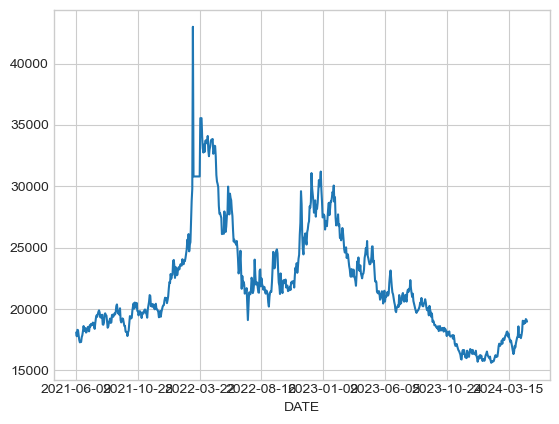

In [98]:
fig = df['기준가격'].plot()

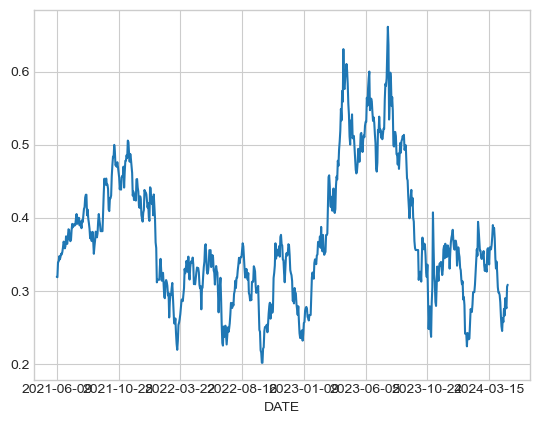

In [99]:
fig = df['평균주가'].plot()

In [100]:
X = df.drop(drop_columns, axis=1) # X, y 분리
y = df[['기준가격']]

In [101]:
y

,기준가격
DATE,
2021-06-09,18088
2021-06-10,17783
2021-06-11,18303
2021-06-14,18276
2021-06-15,17909
...,...
2024-04-24,18985
2024-04-25,18855
2024-04-26,19180


In [102]:
X.fillna(0,inplace=True)
X.isna().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 2021-06-09 to 2024-04-30
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   광물종합지수   731 non-null    float64
 1   메이저금속지수  731 non-null    float64
 2   환율       731 non-null    float64
 3   시장전망지표   731 non-null    float64
 4   무역수지     731 non-null    float64
 5   평균주가     731 non-null    float64
dtypes: float64(6)
memory usage: 40.0+ KB


In [103]:
X

,광물종합지수,메이저금속지수,환율,시장전망지표,무역수지,평균주가
DATE,,,,,,
2021-06-09,2407.510943,2494.113774,1116.890015,12.57,-26962.0,0.319387
2021-06-10,2436.458355,2523.494802,1116.410034,12.57,-26962.0,0.318924
2021-06-11,2452.915918,2519.403176,1111.260010,12.57,-26962.0,0.339419
2021-06-14,2498.367968,2567.594194,1115.550049,12.57,-26962.0,0.340353
2021-06-15,2496.551463,2564.669309,1116.319946,12.57,-26962.0,0.347506
...,...,...,...,...,...,...
2024-04-24,2886.010511,2500.915660,1370.479980,44.88,-19126.0,0.290111
2024-04-25,2895.915528,2521.507684,1376.969971,44.88,-19126.0,0.280054
2024-04-26,2917.287957,2545.055457,1371.699951,44.88,-19126.0,0.276373


## 2. 8:2 로 train test 분리

In [104]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ms = MinMaxScaler() # 0 ~ 1
ss = StandardScaler() # 평균 0, 분산 1

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:725, :] 
X_test = X_ss[725:, :]

y_train = y_ms[:725, :]
y_test = y_ms[725:, :]

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (725, 6) (725, 1)
Testing Shape : (6, 6) (6, 1)


In [105]:
# 데이터셋 형태 및 크기 조정
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, 
                                  (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_f = torch.reshape(X_test_tensors,
                                (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape :', X_train.shape, y_train.shape)
print('Testing Shape :', X_test.shape, y_test.shape)

Training Shape : (725, 6) (725, 1)
Testing Shape : (6, 6) (6, 1)


## 3. LSTM 모델 설정

In [106]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout_prob=0.0):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer added
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Applying dropout before the final fully connected layer
        out = self.fc(out)
        return out


In [107]:
num_epochs = 2500
learning_rate = 0.009

input_size=6 # 칼럼 개수
hidden_size=45 # 은닉층 유닛 개수
num_layers=1 # LSTM 계층 개수
dropout_prob = 0.3

num_classes=1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [108]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 오차 계산
    loss.backward() # 기울기 계산
    
    optimizer.step() # 오차 업데이트
    if epoch % 100 == 0 :
        print(f'Epoch : {epoch}, loss : {loss.item():1.5f}')

Epoch : 0, loss : 0.09000
Epoch : 100, loss : 0.00168
Epoch : 200, loss : 0.00089
Epoch : 300, loss : 0.00061
Epoch : 400, loss : 0.00065
Epoch : 500, loss : 0.00047
Epoch : 600, loss : 0.00044
Epoch : 700, loss : 0.00039
Epoch : 800, loss : 0.00035
Epoch : 900, loss : 0.00053
Epoch : 1000, loss : 0.00031
Epoch : 1100, loss : 0.00030
Epoch : 1200, loss : 0.00034
Epoch : 1300, loss : 0.00031
Epoch : 1400, loss : 0.00025
Epoch : 1500, loss : 0.00023
Epoch : 1600, loss : 0.00022
Epoch : 1700, loss : 0.00027
Epoch : 1800, loss : 0.00021
Epoch : 1900, loss : 0.00022
Epoch : 2000, loss : 0.00026
Epoch : 2100, loss : 0.00021
Epoch : 2200, loss : 0.00028
Epoch : 2300, loss : 0.00027
Epoch : 2400, loss : 0.00020


In [109]:
df_x_ss = ss.transform(X)
df_y_ms = ms.transform(y)

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

## 4. 예측된 주식 값과 실제 주식 값을 시각화

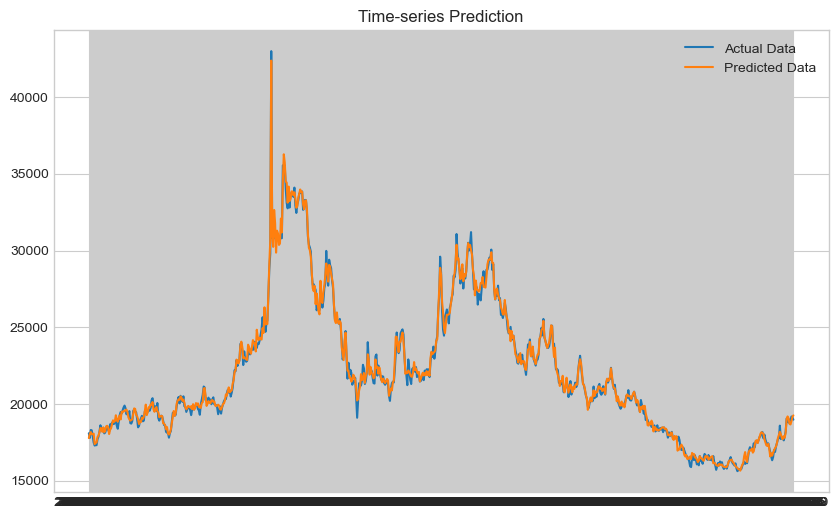

In [110]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()

label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
# plt.axvline(x=datetime(2022,5,1), c='r', linestyle='--')

df['pred'] = predicted
plt.plot(df['기준가격'], label='Actual Data')
plt.plot(df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 5. RMSE 계산

In [111]:
from sklearn.metrics import mean_squared_error
import numpy as np

# 예측값과 실제값을 NumPy 배열로 변환
predicted = np.array(df['pred'])
actual = np.array(df['기준가격'])

# RMSE 계산
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'RMSE: {rmse}')


RMSE: 327.2846290020201


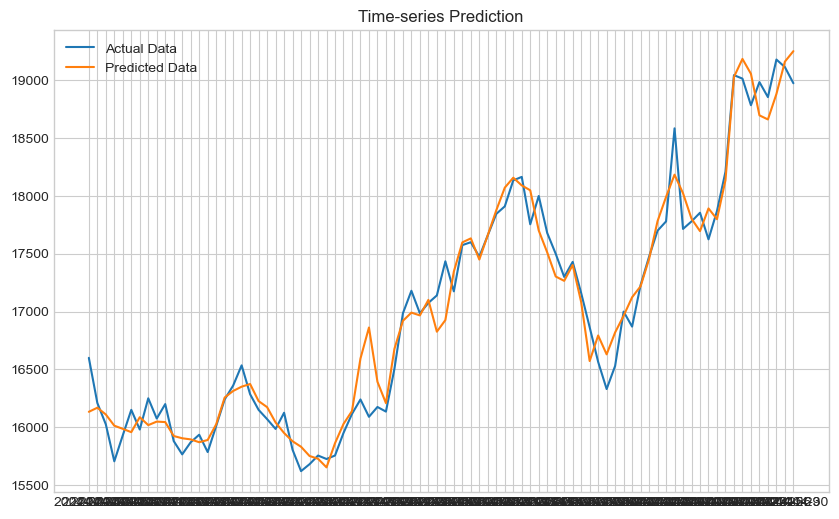

In [112]:
new_df=df.loc['2024-01-01':'2024-04-30']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

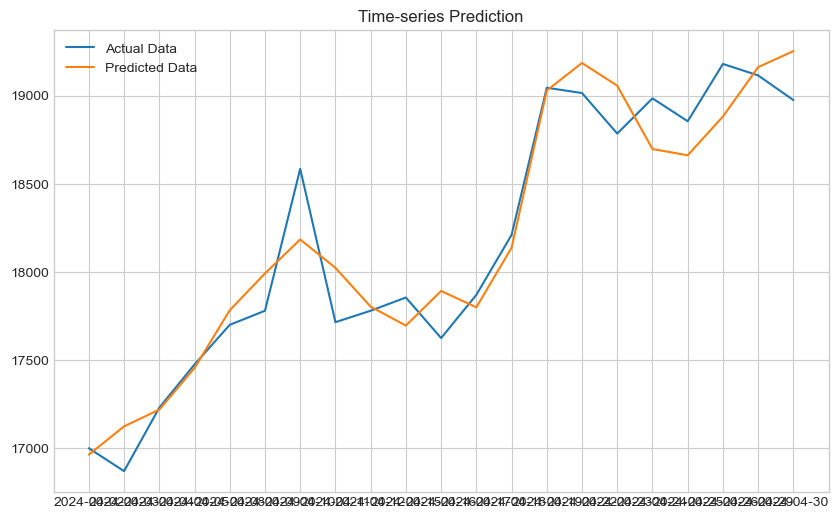

In [113]:
new_df=df.loc['2024-04-01':'2024-04-30']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

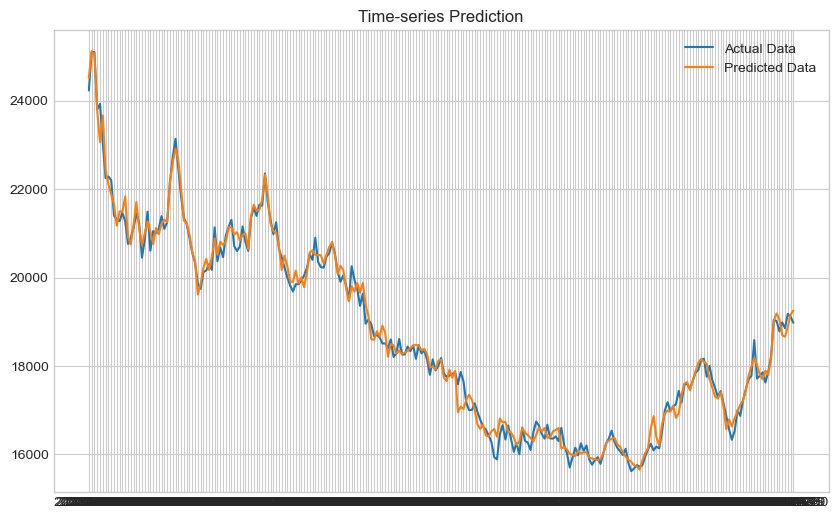

In [114]:
new_df=df.loc['2023-04-30':'2024-04-30']

new_df

plt.figure(figsize=(10, 6))

plt.plot(new_df['기준가격'], label='Actual Data')
plt.plot(new_df['pred'], label='Predicted Data')

plt.title('Time-series Prediction')
plt.legend()
plt.show()

## 6. 데이터 내보내기

In [115]:
df

,기준가격,광물종합지수,메이저금속지수,환율,시장전망지표,무역수지,수출 중량,수출 금액,수입 중량,수입 금액,...,에코프로비엠,에코프로,sk이노베이션,엘앤에프,코스모신소재,롯데에너지머티리얼즈,솔브레인홀딩스,평균주가,수급상태,pred
DATE,,,,,,,,,,,,,,,,,,,,,
2021-06-09,18088,2407.510943,2494.113774,1116.890015,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.000000,0.002092,0.889477,0.000000,0.000000,0.328393,0.285927,0.319387,수급주의,17774.183594
2021-06-10,17783,2436.458355,2523.494802,1116.410034,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.004433,0.002511,0.863166,0.006937,0.002379,0.322835,0.281459,0.318924,수급주의,18033.552734
2021-06-11,18303,2452.915918,2519.403176,1111.260010,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.007149,0.000152,0.889477,0.012713,0.006423,0.338583,0.272524,0.339419,수급주의,18164.876953
2021-06-14,18276,2498.367968,2567.594194,1115.550049,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.007209,0.000455,0.905267,0.023114,0.006900,0.348773,0.285182,0.340353,수급주의,18030.750000
2021-06-15,17909,2496.551463,2564.669309,1116.319946,12.57,-26962.0,0.0,0.0,311072.1,26962.0,...,0.008213,0.000268,0.963163,0.012300,0.004998,0.354331,0.281459,0.347506,수급주의,18025.503906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-24,18985,2886.010511,2500.915660,1370.479980,44.88,-19126.0,102.3,76.0,247605.0,19202.0,...,0.482357,0.380355,0.033163,0.291067,0.610744,0.150533,0.483246,0.290111,수급안정,18697.287109
2024-04-25,18855,2895.915528,2521.507684,1376.969971,44.88,-19126.0,102.3,76.0,247605.0,19202.0,...,0.454861,0.399120,0.019791,0.267836,0.600151,0.148680,0.484736,0.280054,수급안정,18661.890625
2024-04-26,19180,2917.287957,2545.055457,1371.699951,44.88,-19126.0,102.3,76.0,247605.0,19202.0,...,0.459643,0.390736,0.015512,0.279051,0.595818,0.129226,0.481757,0.276373,수급안정,18881.882812


In [116]:
df.to_csv('../../results/니켈lstm.csv',encoding='cp949')